# Logistic Regression
In this notebook, we implement logistic regression and apply it to two diﬀerent datasets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import sklearn.linear_model
from utils.util2 import plotData, plotDecisionBoundary
plt.style.available
plt.style.use('seaborn-v0_8-notebook')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Unregularized Logistic Regression
In this part of the exercise, we build a logistic regression model to
predict whether a student gets admitted into a university. 

Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant’s scores on two exams and the admissions
decision.

We build a classification model that estimates an applicant’s
probability of admission based the scores from those two exams. 

## Visualizing the data
Before starting to implement any learning algorithm, it is always good to
visualize the data if possible. Here we load the
data and display it on a 2-dimensional plot.

In [3]:
data1txt = open('./data/ex2data1.txt').read().replace('\n', ';')
data1 = np.mat(data1txt[:-1])
data1 = np.array(data1)
X1 = np.array(data1[:, 0:-1])
y1 = np.array(data1[:, -1]).flatten()
X1.shape, y1.shape

((100, 2), (100,))

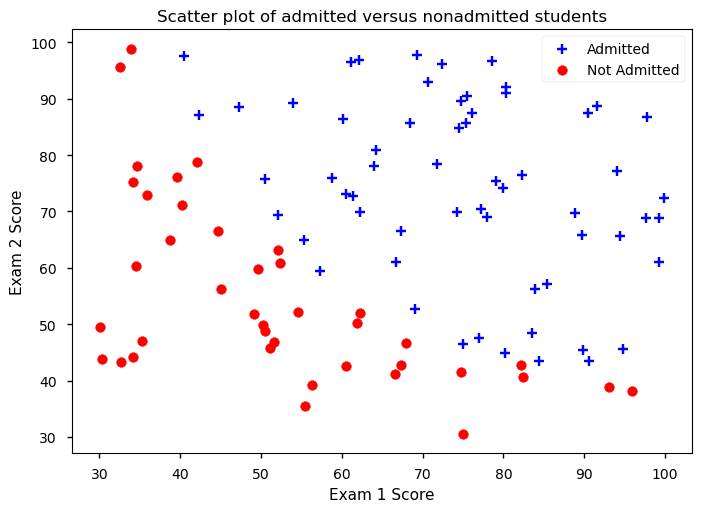

In [4]:
plotData(X1[:, 0:2], y1, labels=["Not Admitted", "Admitted"])
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.title('Scatter plot of admitted versus nonadmitted students')
plt.legend()
plt.show()

## Implementation
### Sigmoid function
Before you start with the actual cost function, recall that the logistic regres-
sion hypothesis is defined as: 
$$h_θ(x) = g(θ^Tx)$$
where function g is the sigmoid function. The sigmoid function is defined as:
$$g(z) = \frac{1}{1 + e^{−z}}$$

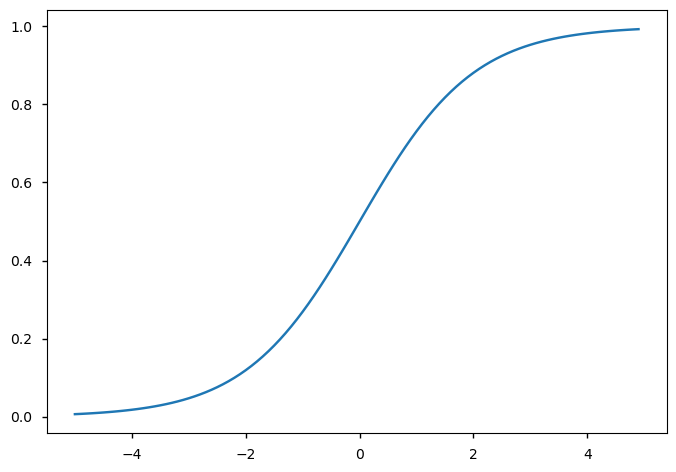

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

xs = np.arange(-5, 5, 0.1)
ys = sigmoid(xs)
plt.plot(xs, ys)
plt.show()

## Cost function and gradient

Now we implement the cost function and gradient for logistic regression.
Complete the code in costFunction.m to return the cost and gradient. Recall that the cost function in logistic regression is defined as:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]
$$


And the gradient of the cost is a vector of the same length as $(\theta)$ where the (j)-th element (for (j = 0, 1, \dots, n)) is defined as follows:

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)}
$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$. 

Finally, we call `costFunction` using the initial parameters of θ. We see that the cost is about 0.693.

In [6]:
def hypothesis(X):  
    ones = np.ones((X.shape[0], 1))
    X_padded = np.hstack((ones, X))
    return  lambda theta: sigmoid(X_padded @ theta)

def computeCost(X, y):
    """
    Compute the cost function and gradients for logistic regression using Mean Squared Error (MSE).
    """
    m = len(y)
    ones = np.ones((m, 1))
    X_padded = np.hstack((ones, X))
    epsilon = 1e-10  # to avoid log(0)
    
    def J(theta): 
        h = sigmoid(X_padded @ theta) + epsilon # to avoid log(0)
        return np.sum(-y*np.log(h) - (1-y)*np.log(1-h)) / m

    def Jdot(theta): 
        h = sigmoid(X_padded @ theta)
        return (1 / m) * (h - y) @ X_padded

    return J, Jdot

In [7]:
theta0 = [0, 0, 0]
J, Jdot = computeCost(X1, y1)
J(theta0)

0.6931471805199452

In [8]:
def gradientDescent(X, y, theta0=None, learning_rate=0.01, iterations=5000):
    """
    Perform logistic regression using gradient descent to minimize 
    the cost function by fitting best theta.
    """
    theta = np.zeros(X.shape[1]+1) if theta0 is None else theta0
    J, Jdot = computeCost(X, y)
    H = hypothesis(X)
    predictions, costs, grads = [], [], []
    for _ in range(iterations):
        p, c, g = H(theta), J(theta), Jdot(theta)
        theta -= learning_rate * g
        predictions.append(p) 
        costs.append(c) 
        grads.append(g)
    return {'theta': theta, 'costs': costs, 'gradients': grads, 'predictions': predictions}

In [9]:
theta_opt1 = gradientDescent(X1, y1, learning_rate=0.01, iterations=500000)['theta']
theta_opt1, computeCost(X1, y1)[0](theta_opt1)

(array([-58.74690236,   0.49651361,   0.48899758]), nan)

### Learning Parameters Using `scipy.minimze`

In the previous assignment, we found the optimal parameters of a regression model by implementing gradient descent. We wrote a cost function and calculated its gradient, then took a gradient descent step accordingly.

This time, instead of taking gradient descent steps, we will use a built-in optimization solver provided by libraries like SciPy in Python that is analogous to MATLAB/Octave’s `fminunc`.

In Python, `fminunc` can be approximated by using the `minimize` function from the `scipy.optimize` module. This function finds the minimum of an unconstrained function.

For logistic regression, you want to optimize the cost function $ J(\theta) $ with respect to the parameters $ \theta $.

Concretely, we are going to use `minimize` to find the best parameters $ \theta $ for the logistic regression cost function, given a fixed dataset (of `X` and `y` values). You will pass to `minimize` the following inputs:

- The initial values of the parameters we are trying to optimize.
- A function that, when given the training set and a particular $ \theta $, computes the logistic regression cost and gradient with respect to $ \theta $ for the dataset (`X`, `y`).

After fitting the model, we call the cost function using the optimal parameters of θ. You should see that the cost is about 0.203.

This final θ value will then be used to plot the decision boundary on the training data

In [10]:
def logistic(X, y, theta0=None):
    """
    Performs logistic regression using a numerical optimization algorithm (L-BFGS-B) to minimize the cost function.
    """

    if theta0 is None: theta0 = np.zeros(X.shape[1]+1)
    J, Jdot = computeCost(X, y)
    result = scipy.optimize.minimize(fun=J, jac=Jdot, x0=theta0, method='L-BFGS-B')
    return result

In [11]:
theta_opt = logistic(X1, y1).x
theta_opt, computeCost(X1, y1)[0](theta_opt)

(array([-25.16141038,   0.20623233,   0.20147212]), 0.2034977015865453)

In [12]:
model = sklearn.linear_model.LogisticRegression()
model.fit(X1, y1)
model.intercept_, model.coef_

(array([-25.05219314]), array([[0.20535491, 0.2005838 ]]))

### Plotting Decision Boundary
We use the final θ value to plot the decision boundary on the training data

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

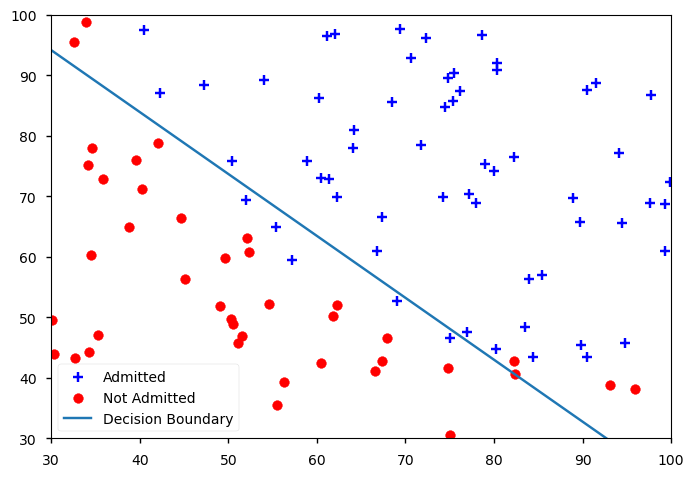

In [13]:
plotDecisionBoundary(theta_opt, X1, y1)

### Evaluating Logistic Regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission probability of 0.776.

Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in `predict.m`. The `predict` function will produce “1” or “0” predictions given a dataset and a learned parameter vector `θ`.

We now proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [14]:
student = np.array([1, 45, 85])
sigmoid(student @ theta_opt)

0.7762897941616127

In [15]:
def predict(X, theta):
    """Similar to hypothesis, but X, and theta are both given as arguments"""
    ones = np.ones((X.shape[0], 1))
    X_padded = np.hstack((ones, X))
    return sigmoid(X_padded @ np.array(theta))

In [16]:
def accuracy(X, y, theta):
    predictions = predict(X, theta)
    accuracy = np.sum((predictions > 0.5) == y) / len(y)
    return accuracy

accuracy(X1, y1, theta_opt)

0.89

# Regularized logistic regression
In this part of the exercise, we implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assur-
ance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two diﬀerent tests. From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

In [17]:
data2txt = open('./data/ex2data2.txt').read().replace('\n', ';')
data2 = np.mat(data2txt[:-1])
data2 = np.array(data2)
data2.shape

(118, 3)

In [18]:
X2 = np.array(data2[:, 0:-1])
y2 = np.array(data2[:, -1]).flatten()
X2.shape, y2.shape

((118, 2), (118,))

## Visualizing the data
Similar to the previous parts of this exercise, plotData is used to generate a
figure like Figure 3, where the axes are the two test scores, and the positive
(y = 1, accepted) and negative (y = 0, rejected) examples are shown with
diﬀerent markers.

Note that the dataset cannot be separated into positive and
negative examples by a straight-line through the plot. Therefore, a straight-
forward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

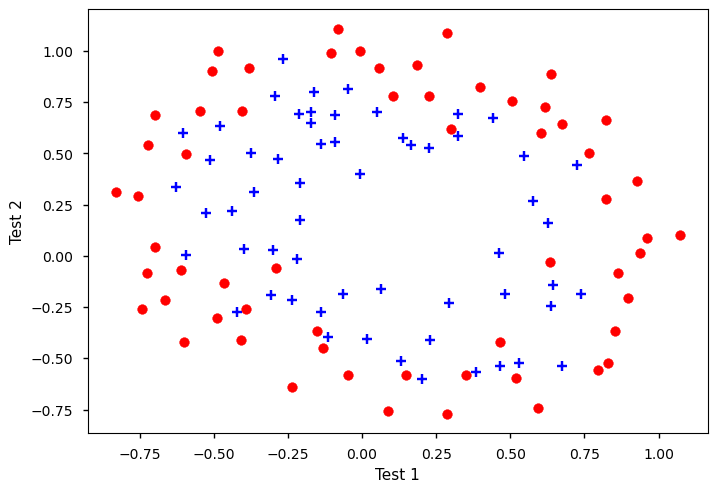

In [19]:
plotData(X2[:, 0:2], y2)
plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.show()

## Feature Mapping

One way to fit the data better is to create more features from each data point. 
In the provided function `mapFeature.m`, we will map the features into all polynomial terms of 
$x_1$ and $x_2$ up to the sixth power.

$$
\text{mapFeature}(x) =
\begin{bmatrix}
1 \\
x_1 \\
x_2 \\
x_1^2 \\
x_1 x_2 \\
x_2^2 \\
x_1^3 \\
\vdots \\
x_1 x_2^5 \\
x_2^6
\end{bmatrix}
$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed 
into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimensional feature 
vector will have a more complex decision boundary and will appear nonlinear when drawn in a 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also becomes more susceptible 
to overfitting. In the next parts of the exercise, you will implement regularized logistic regression 
to fit the data, and also see for yourself how regularization can help combat the overfitting problem.

In [20]:
def mapFeature(u, v, degree = 6):
    """
    Generates polynomial features for two input variables, `u` and `v`, up to the specified degree.

    This function is used to map two input features into a higher-dimensional feature space for use
    in creating polynomial decision boundaries, especially commonly used in machine learning algorithms
    such as logistic regression for classification tasks.
    """
    out = np.ones(1)
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            out = np.append(out, (u ** (i - j)) * (v ** j))
    return out

In [21]:
def mapMatrix(U, V, degree = 6):
    """
    Applies polynomial feature mapping to vectors `U` and `V` element-wise, creating a matrix of mapped features.

    This function extends `mapFeature` to handle arrays of input features `U` and `V`, generating
    a matrix of polynomial features for training machine learning models that involve feature expansion.
    """
    out = []
    m = U.shape[0]
    for i in range(m):
        out.append(mapFeature(U[i], V[i], degree))
    return np.array(out)

In [22]:
mapFeature(X1[0, 0], X1[0, 1], 3)

array([1.00000000e+00, 3.46236596e+01, 7.80246928e+01, 1.19879781e+03,
       2.70150041e+03, 6.08785269e+03, 4.15067672e+04, 9.35358305e+04,
       2.10783739e+05, 4.75002836e+05])

In [23]:
mapMatrix(X1[:, 0], X1[:, 1], 3).shape

(100, 10)

In [24]:
fit1 = logistic(X2, y2)
theta1 = fit1.x
accuracy(X2, y2, theta1)

0.5508474576271186

## Cost Function and Gradient

Now we implement code to compute the cost function and gradient for regularized logistic regression. 
The code in `costFunctionReg` to returns the cost and gradient.

Recall that the regularized cost function in logistic regression is:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2
$$

Note that you should not regularize the parameter $ \theta_0 $.

The gradient of the cost function is a vector where the jth element is defined as follows:

For $ j = 0 $:

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_0^{(i)}
$$

For $ j \geq 1 $:

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j
$$

Finally, we call `costFunctionReg` function using the initial value of $ \theta $ (initialized to all zeros). 
We should see that the cost is about 0.693.

In [25]:
def costFunctionReg(X, y, lambda_=0):
    """
    Regularized version for the cost function and gradients for logistic regression using Mean Squared Error (MSE).
    """
    m = len(y)
    ones = np.ones((m, 1))
    X_padded = np.hstack((ones, X))
    epsilon = 1e-10  # to avoid log(0)
    
    def J(theta): 
        h = sigmoid(X_padded @ theta) + epsilon # to avoid log(0)
        cost_base = np.sum(-y*np.log(h) - (1-y)*np.log(1-h)) / m
        cost_reg = (lambda_/2/m) * np.sum(theta**2)
        return cost_base + cost_reg

    def Jdot(theta): 
        h = sigmoid(X_padded @ theta)
        gradient_base = (1 / m) * (h - y) @ X_padded
        gradient_reg = (lambda_/m) * theta
        gradient_reg[0] = 0
        return gradient_base + gradient_reg

    return J, Jdot

In [26]:
j, jdot = costFunctionReg(X2, y2)
theta0 = np.array([0, 0, 0])
j(theta0)

0.6931471805633354

###  Learning parameters using fminunc
Similar to the previous parts, we will use `scipy.minimize` to learn the optimal
parameters θ.

In [27]:
scipy.optimize.minimize(fun=j, jac=jdot, x0=theta0, method='L-BFGS-B')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.690241122018006
        x: [-1.419e-02 -3.035e-01 -1.813e-02]
      nit: 5
      jac: [-5.454e-07 -2.858e-08 -1.370e-07]
     nfev: 7
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

## Plotting the Decision Boundary

To help visualize the model learned by this classifier, we have provided the function `plotDecisionBoundary`, 
which plots the (non-linear) decision boundary that separates the positive and negative examples. 
In `plotDecisionBoundary.m`, we plot the non-linear decision boundary by computing the classifier’s predictions 
on an evenly spaced grid, and then we create a contour plot where the predictions transition from `y = 0` to `y = 1`.

we try different regularization parameters for the dataset to understand how regularization prevents overfitting. Notice the changes in the decision boundary as you vary `λ`. 

With a small `λ`, we find that the classifier gets almost every training example correct but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, the classifier predicts that a point at `x = (-0.25, 1.5)` is accepted (`y = 1`), which seems to be an incorrect decision given the training set.

With a larger `λ`, we see a plot with a simpler decision boundary that still separates the positives and negatives fairly well. However, if `λ` is set too high, the decision boundary will not fit the data well, thus underfitting the data.

In [28]:
def mapFeaturesFitModelPlotBoundary(X, y, degree=6, lambda_=1):
    X_new = mapMatrix(X[:, 0], X[:, 1], degree)
    X_new = X_new[:, 1:]
    j, jdot = costFunctionReg(X_new, y, lambda_)
    theta0 = np.zeros((X_new.shape[1]+1, ))
    fit =  scipy.optimize.minimize(fun=j, jac=jdot, x0=theta0, method='L-BFGS-B')
    theta = fit.x
    acc = accuracy(X_new, y, theta)
    plotDecisionBoundary(theta, X_new, y, degree)
    plt.title(f"Decision Boundary with Degree {degree} and Lambda {lambda_}")
    return {'theta':theta, 'accuracy':acc}

'No regularization causing overfitting (λ=0)'

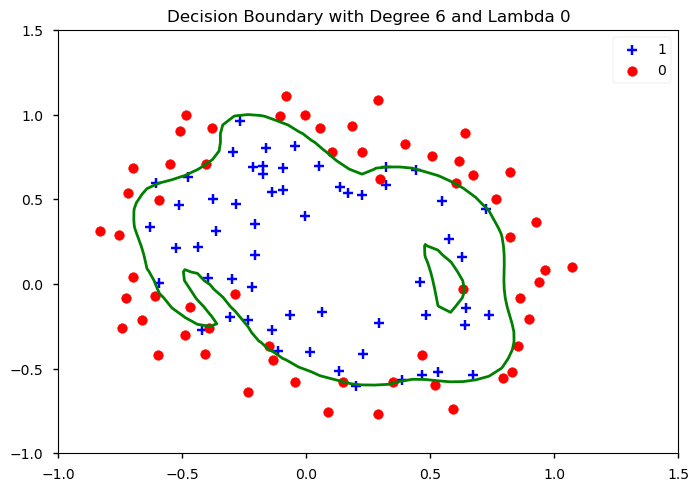

In [29]:
mapFeaturesFitModelPlotBoundary(X2, y2, lambda_=0)
"No regularization causing overfitting (λ=0)"

'Right level of regularization (λ=1)'

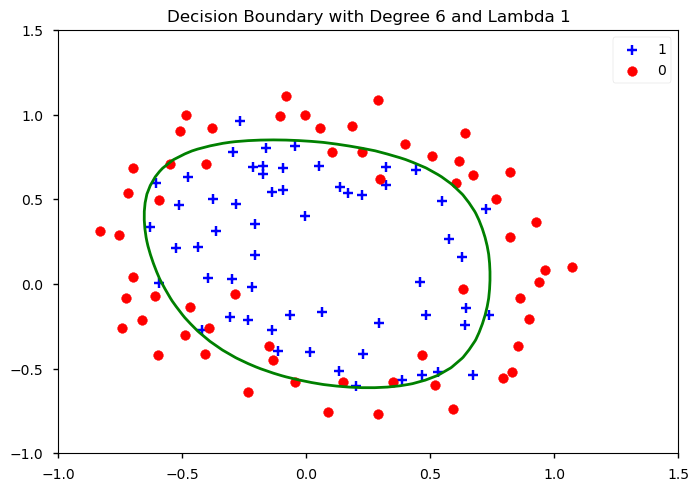

In [30]:
mapFeaturesFitModelPlotBoundary(X2, y2, lambda_=1)
"Right level of regularization (λ=1)"

'Too much regularization causing underfitting (λ=100)'

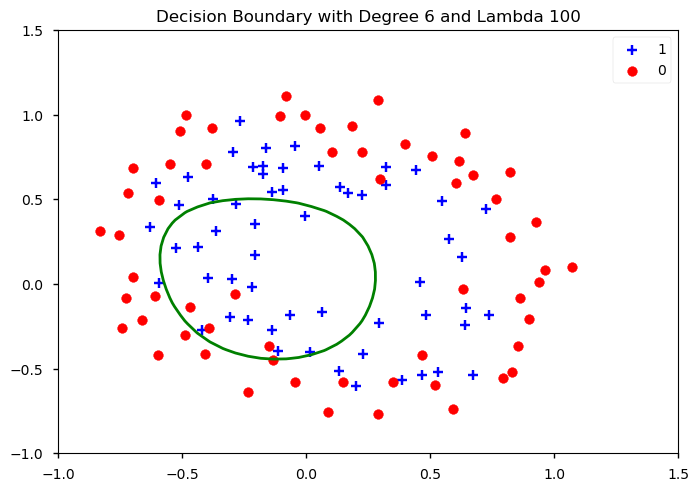

In [31]:
mapFeaturesFitModelPlotBoundary(X2, y2, lambda_=100)
"Too much regularization causing underfitting (λ=100)"